Author: Lynn Menchaca

Date: 23Nov2022

Project: Mental Health Classifier from Tweets

Resources:

- Kaggle Data Set: Tweet Mental Health Classification
    - https://www.kaggle.com/competitions/tweet-mental-health-classification/data?select=train.csv
- Youtube: Ken Jee -> Data Science Project from Scratch - Part 4 (Exploratory Data Analysis)
    - https://www.youtube.com/watch?v=QWgg4w1SpJ8&list=PL2zq7klxX5ASFejJj80ob9ZAnBHdz5O1t&index=4
- plot confusion matrix
    - https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

The purpose of this project is design a model to identify mental health in tweets.

### Project Overview

### Data Processing and Analysis
- Initial Overview: size, collumns, data types, missing values
- Make copy of train data to play with
- Remove duplicate rows
- Clean the tweets
    - Remove any characters that are not letters
    - Removing stop words: and, it, ... (don't have much importance)
    - keep just stem words
- Create a word cloud for each Mental Health Label

### Feature Engineering
- Combine Test and Train Data
- Missing Data -> By end of this step all rows are filled in
- Format Data: strings, temporal varialbes -> 
    By end of this step all columns are ready for final processing and cleaning
- Treating Outliers
- Scaling/Transformation
- Encoding methods
- Handel Imbalance Data set
- Split Test and Train Data -> Export both to csv file for Feature Selection Process

In [22]:
import pandas as pd
import numpy as np
import re
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier

In [2]:
# Data Frames

data_file_path = '/Users/lynnpowell/Documents/DS_Projects/Data_Files/Tweet_Mental_Health_Data/'
df_test = pd.read_csv(data_file_path+'test.csv')
df_train = pd.read_csv(data_file_path+'train.csv')
df_train.head()

,tweets,labels
0,sending solidarity whoever doctor manage incre...,Stressed
1,need see hair amp beard gat book appointment b...,Anxious
2,next time meet someone new dont ask ask love,Normal
3,surprise someone love give la senza gift box r...,Lonely
4,raise hand junhoes ocean lotion life rent free...,Normal


In [3]:
#Overview of data

print('Train Data')
print(df_train.shape)
print(df_train.isnull().sum())
print('\n')
print('test Data')
print(df_test.shape)
print(df_test.isnull().sum())

Train Data
(29992, 2)
tweets    0
labels    0
dtype: int64


test Data
(7499, 2)
id        0
tweets    0
dtype: int64


There is no missing data from both the test and training data. This makes sense since there is only one dependant and independant feature in the training data. If there was any missing data in the training data set the row would have been removed.

In [4]:
print(df_train.dtypes)
print(df_test.dtypes)

tweets    object
labels    object
dtype: object
id         int64
tweets    object
dtype: object


The test and training data do not need to be formated.

In [5]:
#creating a copy of the training data to investigate 
df_tweets = df_train.copy()
# checking for duplicate data in the training data frame.
print(df_tweets[df_tweets.duplicated()])
print('number of duplicate rows: ', df_tweets[df_tweets.duplicated()].shape[0])

                                                  tweets    labels
97     human need job cant exist amp make art chill cat    Anxious
116    sad thing disinformation truth come damage alr...  Stressed
146    sad thing disinformation truth come damage alr...  Stressed
164    hi ask kindness might big battle life dad need...   Anxious
168    boy get slaughter helpless mother could scream...  Stressed
...                                                  ...       ...
29985  hey friend need another nominee weekstarcompet...   Anxious
29986  sad newscloris insanely talented could make la...  Stressed
29988  name muhammad asif farooqi im pakistan amp sta...    Lonely
29989  moms mad wont go overnight skiing trip 5 peopl...  Stressed
29991  jps gooooo amp suck yuh madda mi haaaaaaaaaaaa...    Lonely

[10615 rows x 2 columns]
number of duplicate rows:  10615


In [6]:
# Removing the duplicate rows
print('Size of training data before removing duplicate rows: ', df_tweets.shape)
df_tweets.drop_duplicates(keep='first',inplace=True)
print('Size of training data before removing duplicate rows: ', df_tweets.shape)

#Reseting the index since rows were dropped
df_tweets.reset_index(inplace=True)
df_tweets.head()

Size of training data before removing duplicate rows:  (29992, 2)
Size of training data before removing duplicate rows:  (19377, 2)


,index,tweets,labels
0,0,sending solidarity whoever doctor manage incre...,Stressed
1,1,need see hair amp beard gat book appointment b...,Anxious
2,2,next time meet someone new dont ask ask love,Normal
3,3,surprise someone love give la senza gift box r...,Lonely
4,4,raise hand junhoes ocean lotion life rent free...,Normal


In [7]:
df_tweets['labels'].value_counts()

Normal      7340
Anxious     5047
Stressed    3556
Lonely      3434
Name: labels, dtype: int64


The training data does not appear to be unbalanced.


In [8]:
# Removing special characters from text in title column
# Removing stop words: and, it, ... (don't have much importance)

ps = PorterStemmer()
corpus = []
full_corpus_string = ''

for i in range(0, len(df_tweets)):
    #replacing any character that is not a/A through z/Z with a blank - used for split
    tweet = re.sub('[^a-zA-Z]', ' ', df_tweets['tweets'][i])
    #uniforms the list to make it easier to go threw each word
    tweet = tweet.lower()
    #split -> each word in to a list
    tweet = tweet.split()
    
    #checking each character for stem and stopwords
    #removing the stop words then performing the steming process
    tweet = [ps.stem(word) for word in tweet if not word in stopwords.words('english')]
    tweet = ' '.join(tweet)
    corpus.append(tweet)
    full_corpus_string += tweet + ' '

In [9]:
#The remaining words for each row.

corpus[:5]

['send solidar whoever doctor manag incred distress situat calmli disinfo',
 'need see hair amp beard gat book appoint barb meanwhil fit stroll enter pot joint life',
 'next time meet someon new dont ask ask love',
 'surpris someon love give la senza gift box rm join telegram wont miss updat surprisesomeoneyoulov lasenzamalaysia lasenza pslasenza pslasenzakl pslasenzamalaysia personalshopperlasenza',
 'rais hand junho ocean lotion life rent free mind ikon domin stanworldikon']

In [10]:
#All the words as one long string

full_corpus_string[:500]

'send solidar whoever doctor manag incred distress situat calmli disinfo need see hair amp beard gat book appoint barb meanwhil fit stroll enter pot joint life next time meet someon new dont ask ask love surpris someon love give la senza gift box rm join telegram wont miss updat surprisesomeoneyoulov lasenzamalaysia lasenza pslasenza pslasenzakl pslasenzamalaysia personalshopperlasenza rais hand junho ocean lotion life rent free mind ikon domin stanworldikon mariposa de barrio teach matter guy fo'

In [11]:
#create a data frame with cleaned tweets
df_corpus_str = pd.DataFrame(corpus,
                            columns = ['tweets'])
df_corpus_str['labels'] = df_tweets['labels']

print(df_corpus_str.head())
print(df_tweets.head())

                                              tweets    labels
0  send solidar whoever doctor manag incred distr...  Stressed
1  need see hair amp beard gat book appoint barb ...   Anxious
2        next time meet someon new dont ask ask love    Normal
3  surpris someon love give la senza gift box rm ...    Lonely
4  rais hand junho ocean lotion life rent free mi...    Normal
   index                                             tweets    labels
0      0  sending solidarity whoever doctor manage incre...  Stressed
1      1  need see hair amp beard gat book appointment b...   Anxious
2      2      next time meet someone new dont ask ask love     Normal
3      3  surprise someone love give la senza gift box r...    Lonely
4      4  raise hand junhoes ocean lotion life rent free...    Normal


In [12]:
df_corpus_str.head()

,tweets,labels
0,send solidar whoever doctor manag incred distr...,Stressed
1,need see hair amp beard gat book appoint barb ...,Anxious
2,next time meet someon new dont ask ask love,Normal
3,surpris someon love give la senza gift box rm ...,Lonely
4,rais hand junho ocean lotion life rent free mi...,Normal


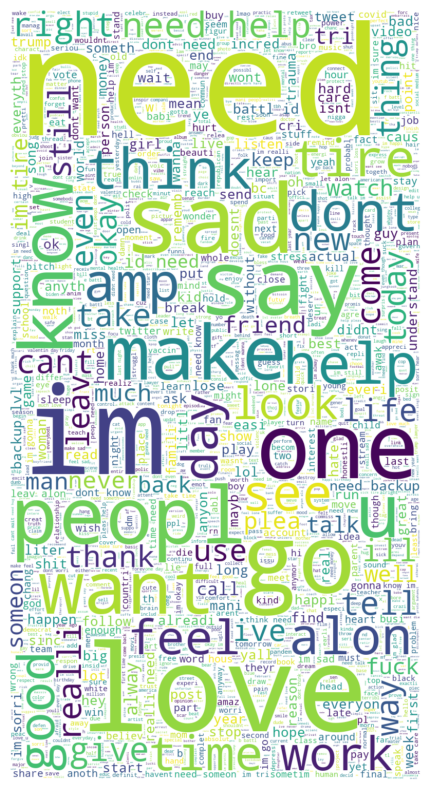

In [13]:
#make a word cloud out of the single sting of cleaned words
#stopwords=STOPWORDS

wc = WordCloud(background_color='white', random_state=3, stopwords=STOPWORDS, max_words=2500, width=800, height=1500)
wc.generate(full_corpus_string)
print(wc)

plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Stressed


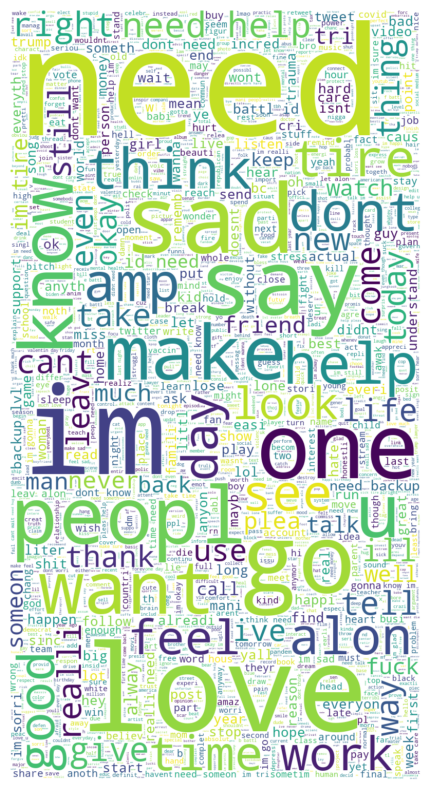

Anxious


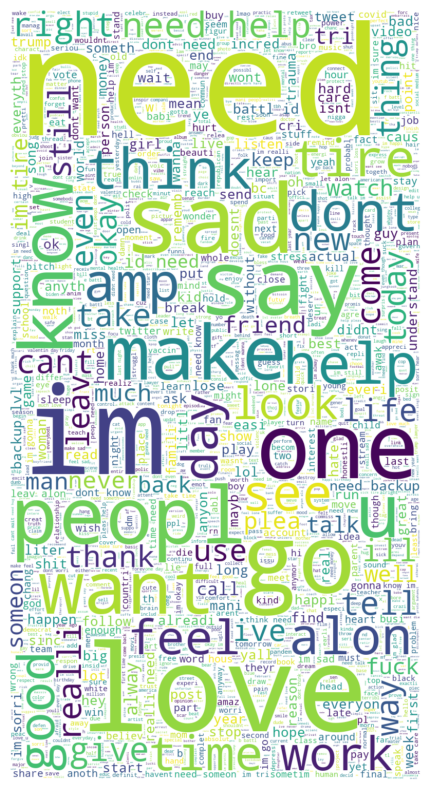

Normal


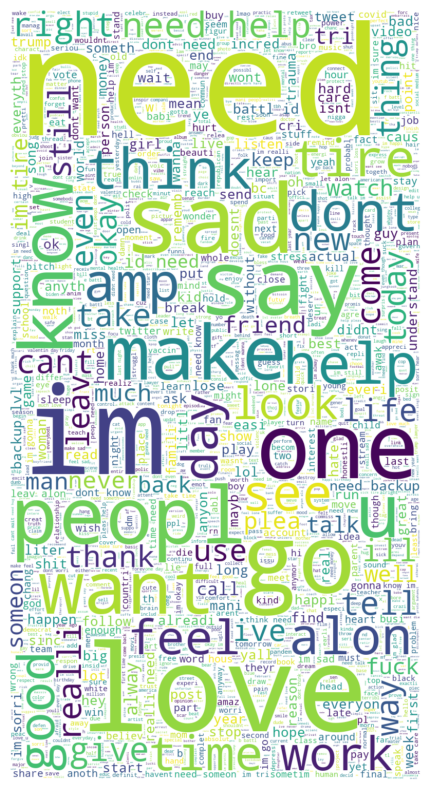

Lonely


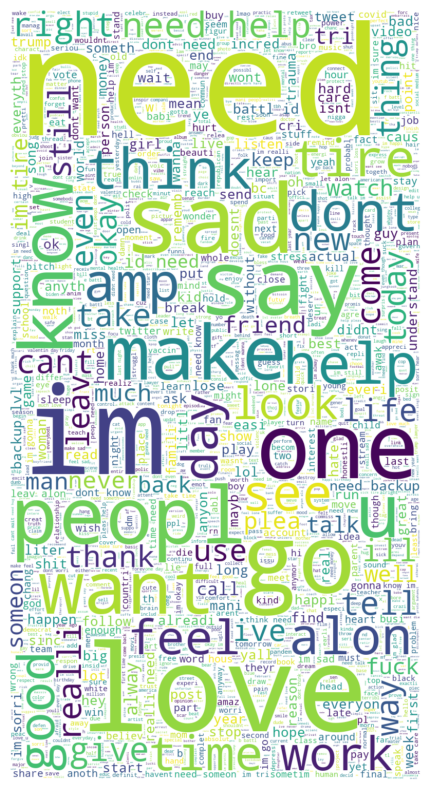

In [14]:
# Creating word clouds

mental_health_labels = df_corpus_str.labels.unique().tolist()
#mental_health_labels = ['Stressed']

for label in mental_health_labels:
    corpus_str_long = ''
    print(label)
    df = df_corpus_str[df_corpus_str.labels == label]
    corpus_str_long = ' '.join(df['tweets'].tolist())
    #print(corpus_str_long)
    
    #Word Cloud plot
    wc = WordCloud(background_color='white', random_state=3, stopwords=STOPWORDS, max_words=2500, width=800, height=1500)
    wc.generate(full_corpus_string)

    plt.figure(figsize=[10,10])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()



In [31]:
# Most common words

mental_health_labels = df_corpus_str.labels.unique().tolist()
#mental_health_labels = ['Stressed']

for label in mental_health_labels:
    corpus_str_long = ''
    print(label)
    df = df_corpus_str[df_corpus_str.labels == label]
    corpus_str_long = ' '.join(df['tweets'].tolist())
    #print(corpus_str_long)
    
    # split() returns list of all the words in the string
    corpus_split = corpus_str_long.split()
    #print(corpus_split)
  
    # Pass the split_it list to instance of Counter class.
    corpus_count = Counter(corpus_split)
  
    # most_common() produces k frequently encountered
    # input values and their respective counts.
    most_occur = corpus_count.most_common(20)
  
    print(most_occur)
    print('\n')
    

Stressed
[('sad', 1407), ('tire', 966), ('im', 938), ('get', 478), ('like', 308), ('peopl', 302), ('make', 276), ('go', 269), ('dont', 249), ('incred', 214), ('say', 212), ('feel', 209), ('see', 201), ('awak', 199), ('know', 196), ('one', 195), ('think', 190), ('time', 184), ('trauma', 180), ('hard', 174)]


Anxious
[('need', 3406), ('im', 2187), ('help', 1265), ('love', 877), ('get', 804), ('dont', 725), ('like', 564), ('go', 532), ('know', 523), ('alon', 475), ('okay', 433), ('want', 418), ('make', 399), ('peopl', 370), ('one', 368), ('time', 343), ('feel', 337), ('think', 329), ('say', 322), ('realli', 313)]


Normal
[('like', 401), ('get', 395), ('im', 367), ('one', 299), ('say', 293), ('go', 282), ('dont', 281), ('trump', 262), ('day', 253), ('love', 252), ('good', 240), ('know', 226), ('make', 224), ('time', 220), ('think', 212), ('peopl', 205), ('amp', 199), ('year', 198), ('new', 196), ('see', 192)]


Lonely
[('need', 2167), ('love', 794), ('im', 548), ('alon', 480), ('dont', 4

Just looking at the top 10 most common words for each mental health label. There is a lot of similar words with stressed, anxious and lonely the order is just a little different.

Stressed: Sad tire I'm get like people make go don't incredible
Anxious: Need I'm help love get don't like go know alone
Lonely: Need love I'm alone don't get like want go help
Normal: Like get i'm one say go don't Trump day love

Stressed: Positive words - 2 (like, incredible)
            Negative words - 3 (sad, tire, don't)
Anxious: Positive words - 2 (love, like)
            Negative words - 3 (need, help, don't, alone)
Lonely: Positive words - 2 (love, like)
            Negative words - 3 (need, alone, don't, help)
Normal: Positive words - - 2 (love, like)
            Negative words - 1 (don't)

### Machine Learning Models:
- Bag of Words Model (Convert strings to a matrix)
    - Count Vectorizer
    - Tfidf Vectorizer
    - Hashing Vectorizer
- Dependant (X) and Independent (y) variables
- Train Test Split
- ML Models with Hyperparameter Tuning
    - Multinomial NM Algorithm
    - Passivie Aggressive Classifer

In [39]:
## Applying Countvectorizer
# Creating the Bag of Words model

from sklearn.feature_extraction.text import CountVectorizer
#max_features = 5000 -> all the words
#ngram_range -> 1, 2 or 3 grouped words
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()
X.shape

(19377, 5000)

In [40]:
#setting the dependant variable
y=df_tweets['labels']
y.shape

(19377,)

In [35]:
#Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

In [41]:
#Looking at the CountVectorizer

#cv.get_feature_names()[:20]
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [ ]:
classifier = MultinomialNB()
classifier.fit(X_train,y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('accuracy: %.3f'%score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE','REAL'])